In [1]:
import torch
import itertools

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
from codes import tensor_ptrace

In [2]:
# Check if GPU or MPS is available, if is then the train process are going to be runned in it.

if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else:
    device = "cpu"

torch.set_default_device(device = device)
print("The process are going to be runned in " + device)

The process are going to be runned in cpu


In [3]:
# Load the dataset previously generated by Learning-QM_data.ipynb

data = list(np.load('data/data_4body_3parts_d2.npz')['arr_0'])
data = [[torch.tensor(d[0]), torch.tensor(d[1])] for d in data]
data = [list(d) for d in data]
print(f"Number of states in the training data: {len(data)}")

Number of states in the training data: 5000


In [4]:
# Define a class for transform the data in torch.tensors to be used by our model

class qmpDataset(Dataset):
    def __init__(self, matrices_list, transform=None):
        super(qmpDataset, self).__init__()
        self.matrices_list = matrices_list
        self.transform = transform

    def __len__(self):
        return len(self.matrices_list)

    def __getitem__(self, idx):
        matrix = self.matrices_list[idx]

        return matrix

In [5]:
# Then, we generate the data and create the iterator

batch_size  = 100
dataset     = qmpDataset(data[:batch_size], transform=torch.Tensor)
dataloader  = DataLoader(dataset, batch_size = batch_size, shuffle = True, generator = torch.Generator(device=device))

noisy, target = next(iter(dataloader))

In [6]:
# Here we define the architecture that, for a 2-channel input matrix gives a 2-channel output matrix that represents the Quantum State.

Scale = 4

class ConvDenoiser(nn.Module):

    def __init__(self):
        super(ConvDenoiser, self).__init__()

        # Encoder: Downsampling with convolutions and average pooling
        self.encoder1 = nn.Sequential(
            nn.Conv2d(2, Scale * 60, kernel_size = 3, padding = 1),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(Scale * 60, Scale * 120, kernel_size = 3, padding = 1),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(Scale * 120, Scale * 60, kernel_size = 3, padding = 1),
            nn.Tanh(),
            nn.AvgPool2d(2, 2)
        )

        # Decoder: Upsampling with transpose convolutions
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(Scale * 60, Scale * 60, kernel_size = 3, padding = 1, stride = 2),
            nn.Tanh(),

            nn.ConvTranspose2d(Scale * 60, Scale * 120, kernel_size = 5, padding = 1, stride = 2),
            nn.Tanh(),

            nn.ConvTranspose2d(Scale * 120, Scale * 60, kernel_size = 6, stride = 2),
            nn.Tanh(),

            nn.Conv2d(Scale * 60, 2, kernel_size = 3)  # Final layer to return to 2 channels
        )

    def forward(self, x):
        # Forward pass through encoder and decoder
        encoded = self.encoder1(x)
        output  = self.decoder1(encoded)
        return output

# Instantiate the model
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (encoder1): Sequential(
    (0): Conv2d(2, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(240, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(480, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder1): Sequential(
    (0): ConvTranspose2d(240, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
    (2): ConvTranspose2d(240, 480, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
    (4): ConvTranspose2d(480, 240, kernel_size=(6, 6), stride=(2, 2))
    (5): Tanh()
    (6): Conv2d(240, 2, kernel_size=(3, 3), stride=(1, 1))
  )
)


In [7]:
# Define the set of parameters to be used in the training stage

dimension   = 2     # Dimension of each qudits, for qubits is 2.
n_qubits    = 4     # Number of qubits of the global state
n_marginal  = 3     # Number of marginal that we know
n_epochs    = 100   # Number of epochs

optimizer   = torch.optim.Adam(model.parameters(), lr = 1e-4)   # The optimizer to be used in the training
loss        = nn.L1Loss()                                       # The loss function to be used in this stage

In [8]:
# Then, we run the training stage where the loss function is minimized through backpropagation algorithms

matrix_size     = dimension ** n_qubits
train_history   = []

labels_margs    = list(itertools.combinations(range(n_qubits), r = n_marginal))
all_systems     = set(list(range(n_qubits)))
identity_tensor = torch.stack([torch.eye(matrix_size) for _ in range(batch_size)])
zeros_tensor    = torch.zeros((batch_size, matrix_size, matrix_size))
ones_for_trace  = torch.vmap(torch.trace)(noisy[:,0,:,:])

In [9]:
# Training loop for the neural network model

for epoch in range(1, n_epochs + 1):
    # Clear the output cell for print
    clear_output(wait = True)

    # Initialize cumulative loss for the epoch
    train_loss = 0.0

    # Iterate over each batch in the dataloader
    for pair in dataloader:
        
        # Unpack the noisy input and the target (ground truth)
        noisy, target = pair
        
        # Reset gradients before backpropagation
        optimizer.zero_grad()

        # Forward pass: generate the model's output from the noisy input
        outputs = model(noisy)

        # Singular Value Decomposition (SVD) on the complex output matrix
        # outputs[:, 0, :, :] is the real part, outputs[:, 1, :, :] is the imaginary part
        U, S, Vh = torch.linalg.svd(outputs[:, 0, :, :] + 1j * outputs[:, 1, :, :])
        
        # Compute the unitary matrix u from SVD: u = U @ Vh
        u = U @ Vh

        # Compute the trace for each batch element using vectorized map (vmap)
        batch_trace = torch.vmap(torch.trace)(outputs[:, 0, :, :])

        # Compute the total loss, which is a sum of different components
        # First loss term: ensure u is close to the identity tensor (real part)
        loss_value = (loss(u.real, identity_tensor) +
                      loss(u.imag, zeros_tensor) +  # Ensure imaginary part is close to zero
                      loss(batch_trace, ones_for_trace))  # Ensure the trace matches expectation
        
        # Additional loss based on partial trace constraints for each label marginal
        for l in labels_margs:
            # Get the complement (subsystems to trace out)
            complement = tuple(all_systems - set(l))
            
            # Add loss for matching partial traces between outputs and targets
            loss_value += loss(tensor_ptrace(outputs, dimension, complement), 
                               tensor_ptrace(target, dimension, complement))
        
        # Backward pass: compute gradients
        loss_value.backward()

        # Update the model parameters based on the computed gradients
        optimizer.step()

        # Accumulate the loss for this batch, scaled by the batch size
        train_loss += loss_value.item() * noisy.size(0)

    # Normalize the accumulated training loss by the total number of samples
    train_loss = train_loss / len(dataloader)

    # Save model checkpoint if the current training loss improves from the previous epoch
    if epoch > 1:
        if train_loss < train_history[epoch - 2]:  # Compare with the loss from the previous epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f"./checkpoint_N{n_qubits}_k{n_marginal}.pth")

    # Append the current training loss to the history
    train_history.append(train_loss)

    # Print the loss for the current epoch
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 100 	Training Loss: 9.143396


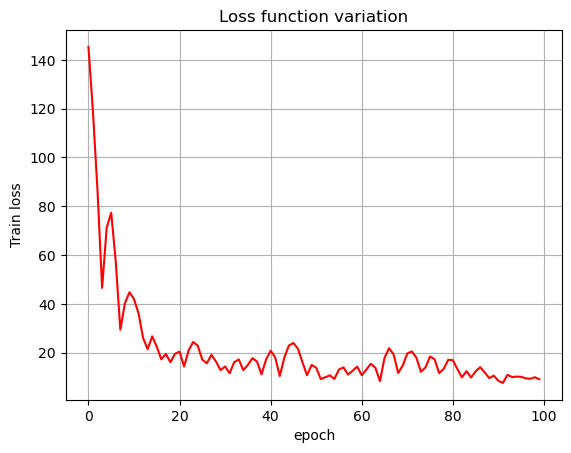

In [10]:
# Let's see how vary the loss function. This plot are going to be important to analyze "how good" is our model

plt.plot(range(len(train_history)), train_history, color="red")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Train loss")
plt.title("Loss function variation")

plt.show()